In [ ]:
# dependecies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scikeras.wrappers import KerasClassifier

In [ ]:
# reading in the data
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
# understanding categorical vs numerical (can also use df.dtypes)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
# checking null values
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [ ]:
# checking duplicated values
data.duplicated().sum()

np.int64(1)

In [7]:
duplicated_rows = data[data.duplicated()]
duplicated_rows

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [ ]:
# handling duplicates
data = data.drop_duplicates()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [10]:
data.duplicated().sum()

np.int64(0)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [ ]:
# categorical => numerical
data['sex_numeric'] = data['sex']

dict_sex = {'sex_numeric': {'female': 1, 'male': 2}}
data.replace(dict_sex, inplace = True)

data['region_numeric'] = data['region']

dict_region = {'region_numeric': {'northeast': 1, 'northwest': 2, 'southeast': 3, 'southwest': 4}}
data.replace(dict_region, inplace = True)

data['smoker_numeric'] = data['smoker']

dict_smoker = {'smoker_numeric': {'yes': 1, 'no': 2}}
data.replace(dict_smoker, inplace = True)

/var/folders/xg/9_zxrtsn0ll10hckyb7z5l780000gn/T/ipykernel_8497/1606379379.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(dict_sex, inplace=True)


In [ ]:
# keeping datasets separate for utilization of both
data_numeric = data.copy()
data_numeric.drop(['sex', 'region', 'smoker'], inplace = True, axis = 1)
data.drop(['sex_numeric', 'region_numeric', 'smoker_numeric'], axis=1, inplace=True)

In [17]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [18]:
data_numeric.head()

,age,bmi,children,charges,sex_numeric,region_numeric,smoker_numeric
0,19,27.900,0,16884.92400,1,4,1
1,18,33.770,1,1725.55230,2,3,2
2,28,33.000,3,4449.46200,2,3,2
3,33,22.705,0,21984.47061,2,2,2
4,32,28.880,0,3866.85520,2,2,2


In [19]:
data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1337 non-null   int64  
 1   bmi             1337 non-null   float64
 2   children        1337 non-null   int64  
 3   charges         1337 non-null   float64
 4   sex_numeric     1337 non-null   int64  
 5   region_numeric  1337 non-null   int64  
 6   smoker_numeric  1337 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 83.6 KB


In [ ]:
# get means, standard deviations, min, max, etc.
data_numeric.describe()

,age,bmi,children,charges,sex_numeric,region_numeric,smoker_numeric
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487,1.504862,2.516081,1.795064
std,14.044333,6.100468,1.205571,12110.359656,0.500163,1.105208,0.403806
min,18.000000,15.960000,0.000000,1121.873900,1.000000,1.000000,1.000000
25%,27.000000,26.290000,0.000000,4746.344000,1.000000,2.000000,2.000000
50%,39.000000,30.400000,1.000000,9386.161300,2.000000,3.000000,2.000000
75%,51.000000,34.700000,2.000000,16657.717450,2.000000,3.000000,2.000000
max,64.000000,53.130000,5.000000,63770.428010,2.000000,4.000000,2.000000


BEGINNING THE VISUALIZATIONS

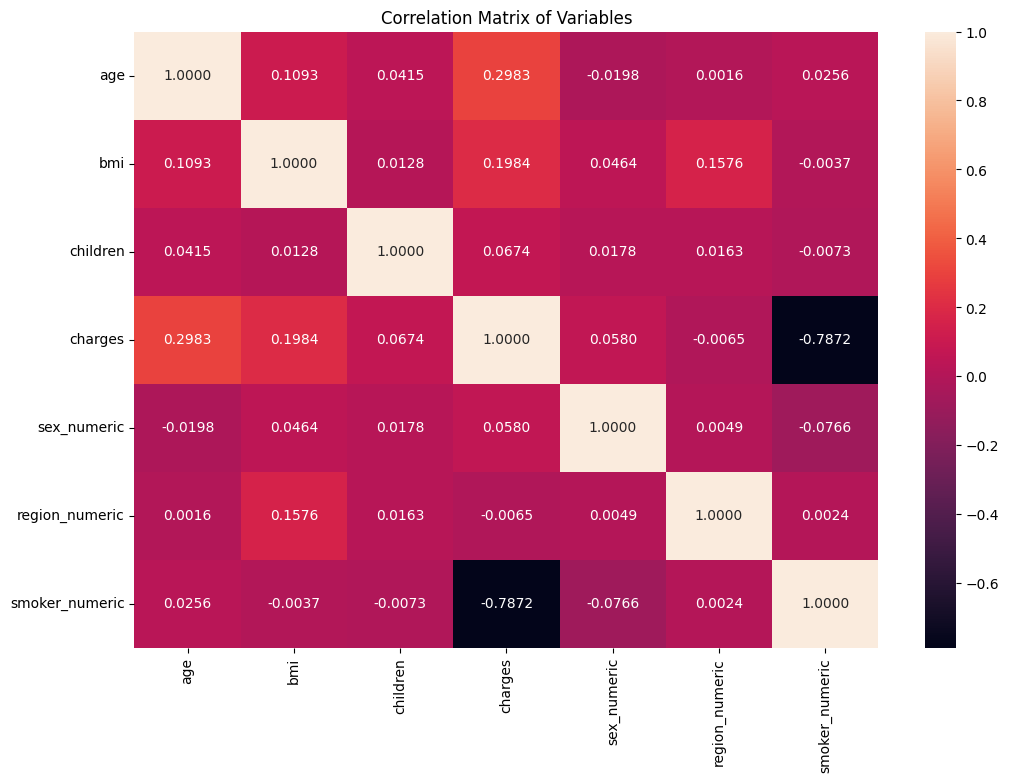

In [25]:
corr = data_numeric.corr()

plt.figure(figsize=[12, 8])
sns.heatmap(corr, annot=True, fmt='.4f')
plt.title('Correlation Matrix of Variables')
plt.show()


nothing really of note; strong negative correlation between smoking & insurance charges

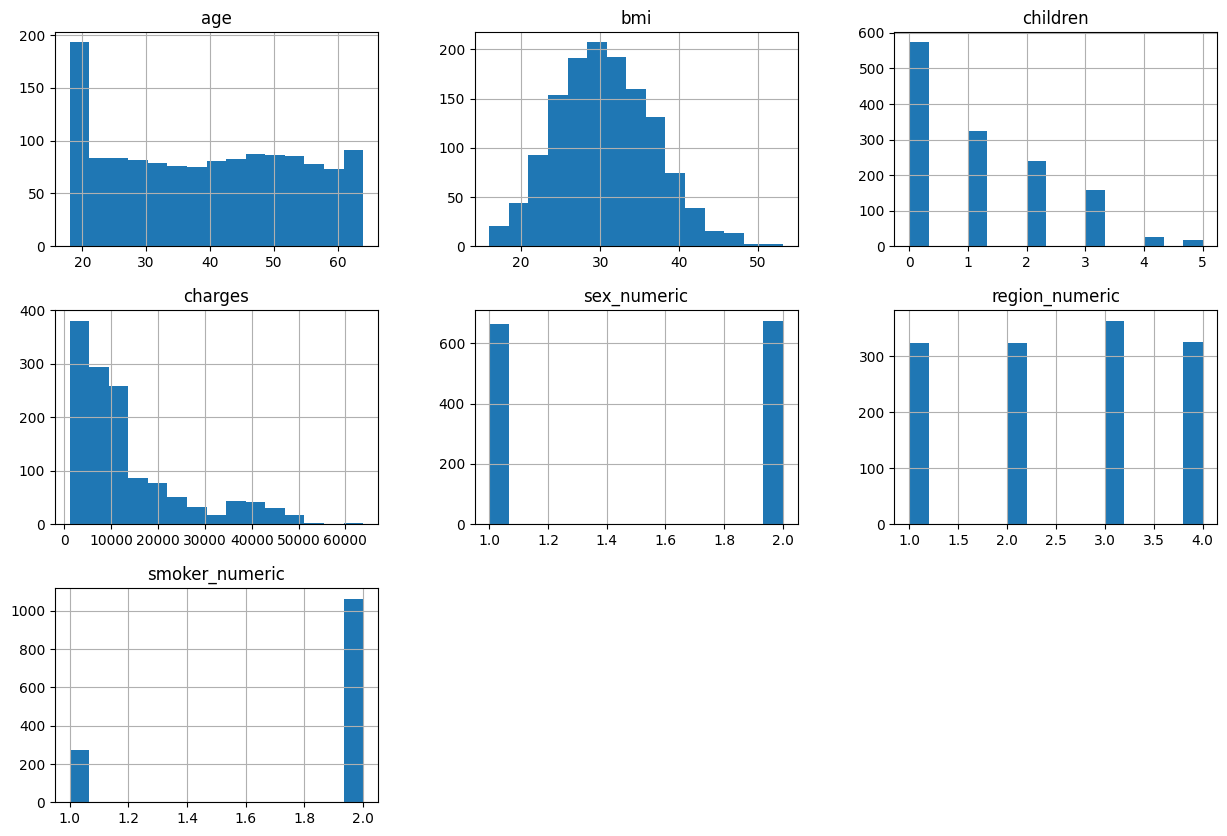

In [ ]:
# histograms
data_numeric.hist(bins=15, figsize=[15,10])
plt.show()

age, children, and charges are skewed to the right. bmi is reminscent of a normal curve. There is evidence of imbalance in age, children, and smoker features.

In [ ]:
# get mean, standard deviation, basic statistics
data_numeric.describe()

,age,bmi,children,charges,sex_numeric,region_numeric,smoker_numeric
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487,1.504862,2.516081,1.795064
std,14.044333,6.100468,1.205571,12110.359656,0.500163,1.105208,0.403806
min,18.000000,15.960000,0.000000,1121.873900,1.000000,1.000000,1.000000
25%,27.000000,26.290000,0.000000,4746.344000,1.000000,2.000000,2.000000
50%,39.000000,30.400000,1.000000,9386.161300,2.000000,3.000000,2.000000
75%,51.000000,34.700000,2.000000,16657.717450,2.000000,3.000000,2.000000
max,64.000000,53.130000,5.000000,63770.428010,2.000000,4.000000,2.000000


<Axes: xlabel='region_numeric', ylabel='charges'>

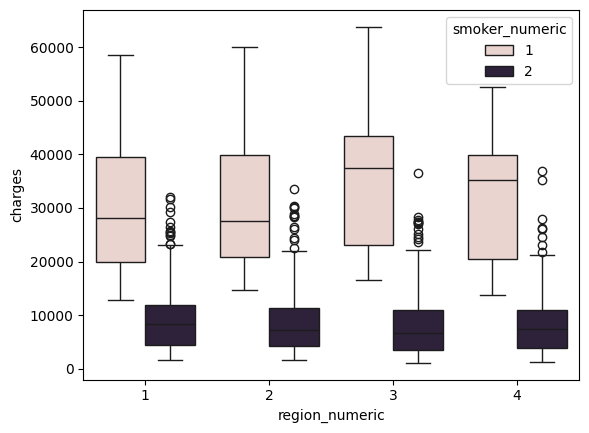

In [43]:
# due to charge feature skew, most outliers are on the higher end. 
sns.boxplot(y='charges', x='region_numeric', hue='smoker_numeric', data=data_numeric)

multiple experimenets with boxplots; can make numerous conclusions about them. 

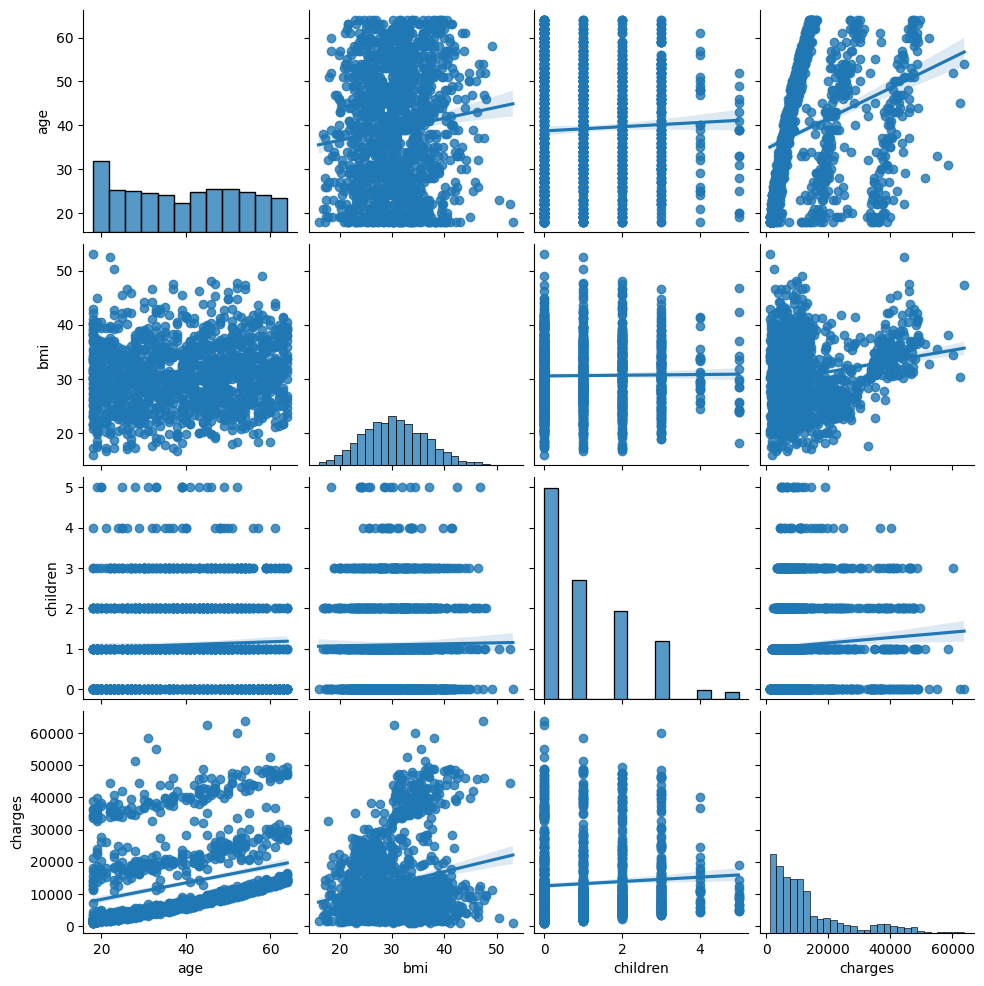

In [45]:
# pairplot video experimentation
sns.pairplot(data, kind='reg')

- detecting numerical features
- histograms on the diagonals; scatter plots everywhere else; can be changed
- use hue for categorical features
- boolean types are treated as numeric
- can specify which exact variables you want to see & which axis they're on 

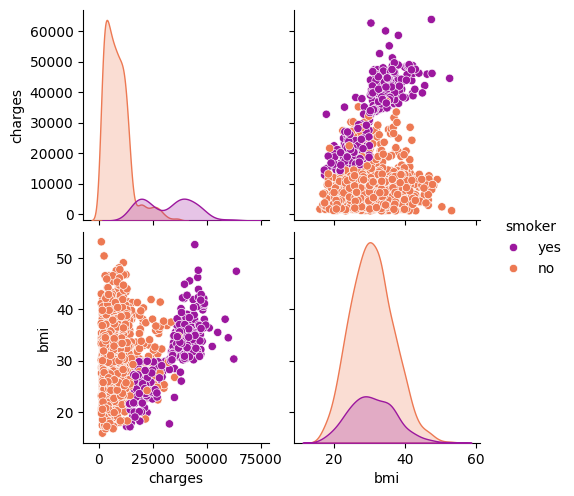

In [54]:
palette = [ '#BF7E81', '#66021F']
sns.pairplot(data, hue='smoker', palette='plasma', vars=['charges', 'bmi'])

<Axes: xlabel='age', ylabel='Density'>

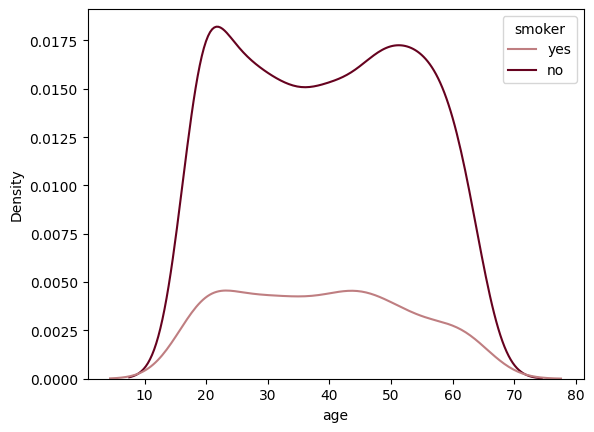

In [ ]:
# to understand a misconception
sns.kdeplot(data, x='age', hue='smoker', palette=palette)

In [57]:
# numerical => categorical for "imbalance"/skew purposes
data['age_category'] = pd.cut(data['age'], bins=[0, 25, 35, 45, 55, 65, 100], labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
data['bmi_category'] = pd.cut(data['bmi'], bins=[0, 18.5, 25, 30, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

In [58]:
data.head()

,age,sex,bmi,children,smoker,region,charges,age_category,bmi_category
0,19,female,27.900,0,yes,southwest,16884.92400,18-25,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,18-25,Obese
2,28,male,33.000,3,no,southeast,4449.46200,26-35,Obese
3,33,male,22.705,0,no,northwest,21984.47061,26-35,Normal
4,32,male,28.880,0,no,northwest,3866.85520,26-35,Overweight


In [59]:
data.to_csv('data_categorical.csv', index=False)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           1337 non-null   int64   
 1   sex           1337 non-null   object  
 2   bmi           1337 non-null   float64 
 3   children      1337 non-null   int64   
 4   smoker        1337 non-null   object  
 5   region        1337 non-null   object  
 6   charges       1337 non-null   float64 
 7   age_category  1337 non-null   category
 8   bmi_category  1337 non-null   category
dtypes: category(2), float64(2), int64(2), object(3)
memory usage: 86.6+ KB


learned quite a lot from that; despite the normal-looking curve for bmi, the results showed heavy skew for overweight & obese individuals

<Axes: xlabel='sex', ylabel='charges'>

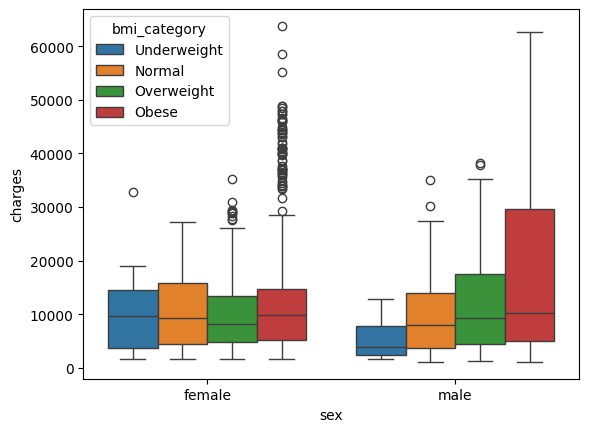

In [62]:
sns.boxplot(y='charges', x='sex', hue='bmi_category', data=data)